In [7]:
import glob
import os

In [29]:
base_path = '/home/gengshan/workJan/poseEstm_rtpose/camData/'

In [32]:
for cls in glob.glob(base_path+'/*'):
    for subcls in glob.glob( cls+'/*'):
        path  = glob.glob( subcls+'/*/')
        print path

['/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/1/20170116_134023/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/1/20170116_134107/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/1/20170116_134047/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/1/20170116_134059/']
['/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/2/20170116_134338/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/2/20170116_134325/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/2/20170116_134331/']
['/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/3/20170116_134525/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/3/20170116_134531/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/3/20170116_134537/']
['/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/4/20170116_134700/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/4/20170116_134648/', '/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup/4/2

In [14]:
glob.glob('/home/gengshan/workJan/poseEstm_rtpose/camData/*')

['/home/gengshan/workJan/poseEstm_rtpose/camData/lhandsup',
 '/home/gengshan/workJan/poseEstm_rtpose/camData/static']

In [1]:
import numpy as np
import json
import mxnet as mx
from poserecog.bucket_io import BucketSentenceIter

import logging

/usr/lib/python2.7/dist-packages/numpy/oldnumeric/__init__.py:11: ModuleDeprecationWarning: The oldnumeric module will be dropped in Numpy 1.9
  warnings.warn(_msg, ModuleDeprecationWarning)


In [2]:
contexts = mx.context.gpu(5)

In [3]:
batch_size = 32  #
disp_batches = 50
buckets = [129]  #
num_epochs = 25
num_hidden = 512
num_lstm_layer = 3
init_c = [('l%d_init_c'%l, (batch_size, num_hidden)) for l in range(num_lstm_layer)]
init_h = [('l%d_init_h'%l, (batch_size, num_hidden)) for l in range(num_lstm_layer)]
init_states = init_c + init_h
invalid_label = 0

In [4]:
init_c

[('l0_init_c', (32, 512)), ('l1_init_c', (32, 512)), ('l2_init_c', (32, 512))]

In [5]:
data_train = BucketSentenceIter(buckets, batch_size,
                                init_states, dataPath = 'out' )

reading from out
categories: set(['static', 'lhandsup'])
label: 0, category: static
out/static_20170116_134123.json
out/static_20170116_134150.json
out/static_20170116_134143.json
out/static_20170116_134345.json
out/static_20170116_134358.json
out/static_20170116_134544.json
out/static_20170116_134550.json
out/static_20170116_134557.json
out/static_20170116_134715.json
out/static_20170116_134708.json
label: 1, category: lhandsup
out/lhandsup_20170116_134023.json
out/lhandsup_20170116_134107.json
out/lhandsup_20170116_134047.json
out/lhandsup_20170116_134059.json
out/lhandsup_20170116_134338.json
out/lhandsup_20170116_134325.json
out/lhandsup_20170116_134331.json
out/lhandsup_20170116_134525.json
out/lhandsup_20170116_134531.json
out/lhandsup_20170116_134537.json
out/lhandsup_20170116_134700.json
out/lhandsup_20170116_134648.json
out/lhandsup_20170116_134654.json
23 samples
Summary of dataset ==================
bucket of len 129 : 736 samples
[('data', (32, 129, 28))]
[('softmax_label',

In [6]:
stack = mx.rnn.SequentialRNNCell()
for i in range(num_lstm_layer):
    stack.add(mx.rnn.LSTMCell(num_hidden=num_hidden, prefix='lstm_l%d_'%i))

In [7]:
def sym_gen(seq_len):
    data = mx.sym.Variable('data')
    label = mx.sym.Variable('softmax_label')
    embed = mx.sym.Embedding(data=data, input_dim=28,
                             output_dim=200, name='embed')

    stack.reset()
    outputs, states = stack.unroll(seq_len, inputs=embed, merge_outputs=True)

    pred = mx.sym.Reshape(outputs, shape=(-1, num_hidden))
    pred = mx.sym.FullyConnected(data=pred, num_hidden=28, name='pred')

    label = mx.sym.Reshape(label, shape=(-1,))
    pred = mx.sym.SoftmaxOutput(data=pred, label=label, name='softmax')

    return pred, ('data',), ('softmax_label',)

In [8]:
model = mx.mod.BucketingModule(
    sym_gen             = sym_gen,
    default_bucket_key  = data_train.default_bucket_key,
    context             = contexts)

In [10]:
model.fit(
    train_data          = data_train,
    eval_data           = data_train,
    eval_metric         = mx.metric.Perplexity(invalid_label),
    kvstore             = 'device',
    optimizer           = 'sgd',
    optimizer_params    = { 'learning_rate': 0.01,
                            'momentum': 0,
                            'wd': 0.00001 },
    initializer         = mx.init.Xavier(factor_type="in", magnitude=2.34),
    num_epoch           = num_epochs,
    batch_end_callback  = mx.callback.Speedometer(batch_size, disp_batches))

KeyboardInterrupt: 

In [29]:
data_train.provide_data

[('data', (32, 129, 28)),
 ('l0_init_c', (32, 512)),
 ('l1_init_c', (32, 512)),
 ('l2_init_c', (32, 512)),
 ('l0_init_h', (32, 512)),
 ('l1_init_h', (32, 512)),
 ('l2_init_h', (32, 512))]

In [39]:
from poserecog.bucket_io import BucketSentenceIter

In [41]:
contexts = mx.context.gpu(5)
batch_size = 1 
num_epochs = 25
disp_batches = 5

input_dim = 28
embed_dim = 256
sequence_length = 10

num_hidden = 10

In [40]:
data_train = BucketSentenceIter(buckets, batch_size,dataPath = 'out' )

reading from out
categories: set(['static', 'lhandsup'])
label: 0, category: static
> /home/gengshan/wmay/dyn_pose/poserecog/bucket_io.py(234)dLoader()
-> for it in data[k]:
(Pdb) c
out/static_20170116_134123.json
label: 1, category: lhandsup
> /home/gengshan/wmay/dyn_pose/poserecog/bucket_io.py(232)dLoader()
-> pdb.set_trace()
(Pdb) c
out/lhandsup_20170116_134023.json
2 samples
Summary of dataset ==================
bucket of len  38 : 2 samples
[('data', (1, 38, 2))]
[('softmax_label', (1, 38))]


In [ ]:
data_train

In [44]:
import mxnet as mx
# Then we create an LSTM cell.
lstm_cell = mx.rnn.LSTMCell(num_hidden=num_hidden)
# Initialize its hidden and memory states.
# 'begin_state' method takes an initialization function, and uses 'zeros' by default.
begin_state = lstm_cell.begin_state()

In [45]:
# Call the cell to get the output of one time step for a batch.
output, states = lstm_cell(embedded_step, begin_state)

In [46]:
# Embed a sequence. 'seq_data' has the shape of (batch_size, sequence_length).
seq_input = mx.symbol.Variable('seq_data')
embedded_seq = mx.symbol.Embedding(data=seq_input, \
                                   input_dim=input_dim, \
                                   output_dim=embed_dim)

In [47]:
# Note that when unrolling, if 'merge_outputs' is set to True, the 'outputs' is merged into a single symbol
# In the layout, 'N' represents batch size, 'T' represents sequence length, and 'C' represents the
# number of dimensions in hidden states.
outputs, states = lstm_cell.unroll(length=sequence_length, \
                                   inputs=embedded_seq, \
                                   layout='NTC', \
                                   merge_outputs=True)

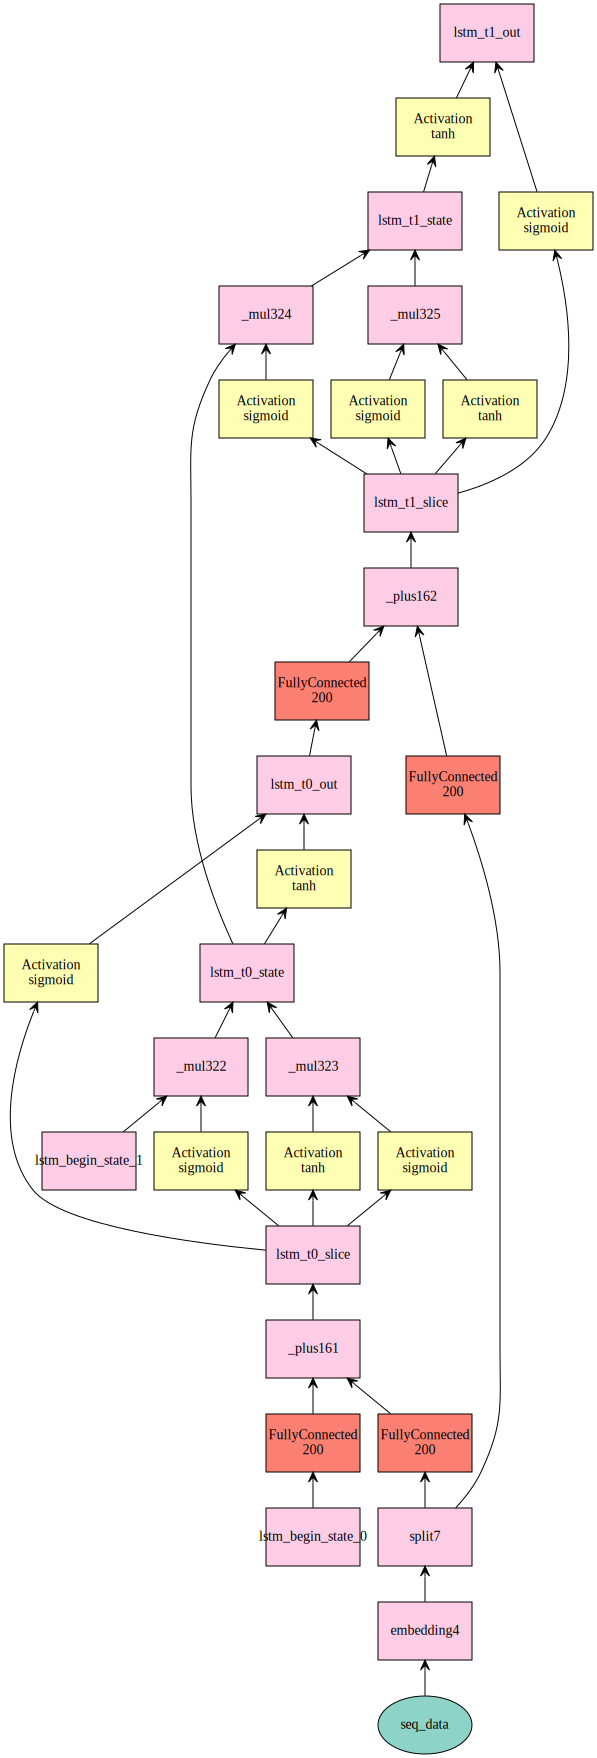

In [48]:
mx.viz.plot_network(outputs2[1])

In [51]:
from poserecog.get_lstm_sym import get_lstm_sym
num_hidden = 200
num_lstm_layer = 2
num_embed = 200


In [54]:
fun = get_lstm_sym(num_hidden=num_hidden, num_lstm_layer=num_lstm_layer,\
                            num_embed=num_embed)

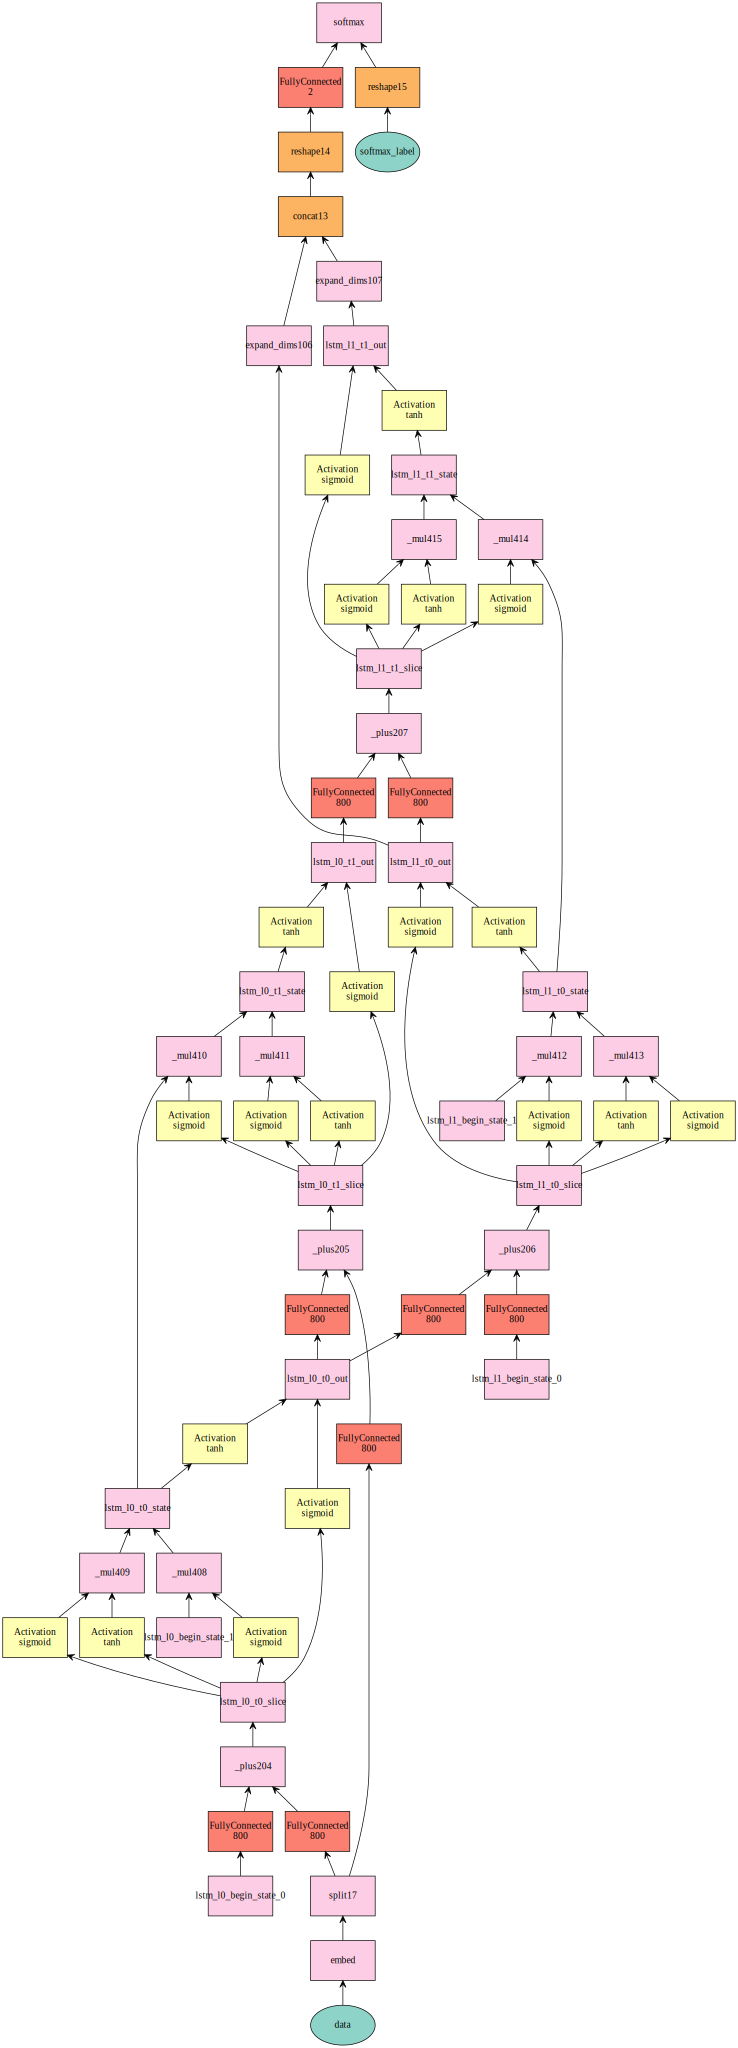

In [63]:
mx.viz.plot_network(fun(2)[0])

In [61]:
fun(2)[0]

<Symbol softmax>